## Для датасета winequality-red.csv провести обработку данных и построить предсказательную модель с использованием функционала pySpark.

### pyspark запускаю в контейнере командой docker run -it -p 8888:8888 jupyter/pyspark-notebook

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

In [2]:
# Создание сессии
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('data_processing').getOrCreate()

In [3]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pyspark

In [26]:
df = spark.read.csv('winequality-red.csv', header=True, sep=";", inferSchema=True)
df.show(10, truncate=False)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|pH  |sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|7.4          |0.7             |0.0        |1.9           |0.076    |11.0               |34.0                |0.9978 |3.51|0.56     |9.4    |5      |
|7.8          |0.88            |0.0        |2.6           |0.098    |25.0               |67.0                |0.9968 |3.2 |0.68     |9.8    |5      |
|7.8          |0.76            |0.04       |2.3           |0.092    |15.0               |54.0                |0.997  |3.26|0.65     |9.8    |5      |
|11.2         |0.28            |0.56       |1.9           |0.075    |17.0               |60.0       

In [17]:
# Изобразим типы данных по колонкам
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [6]:
df.describe().show()

+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|           quality|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599|              1599|
|   mean

/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


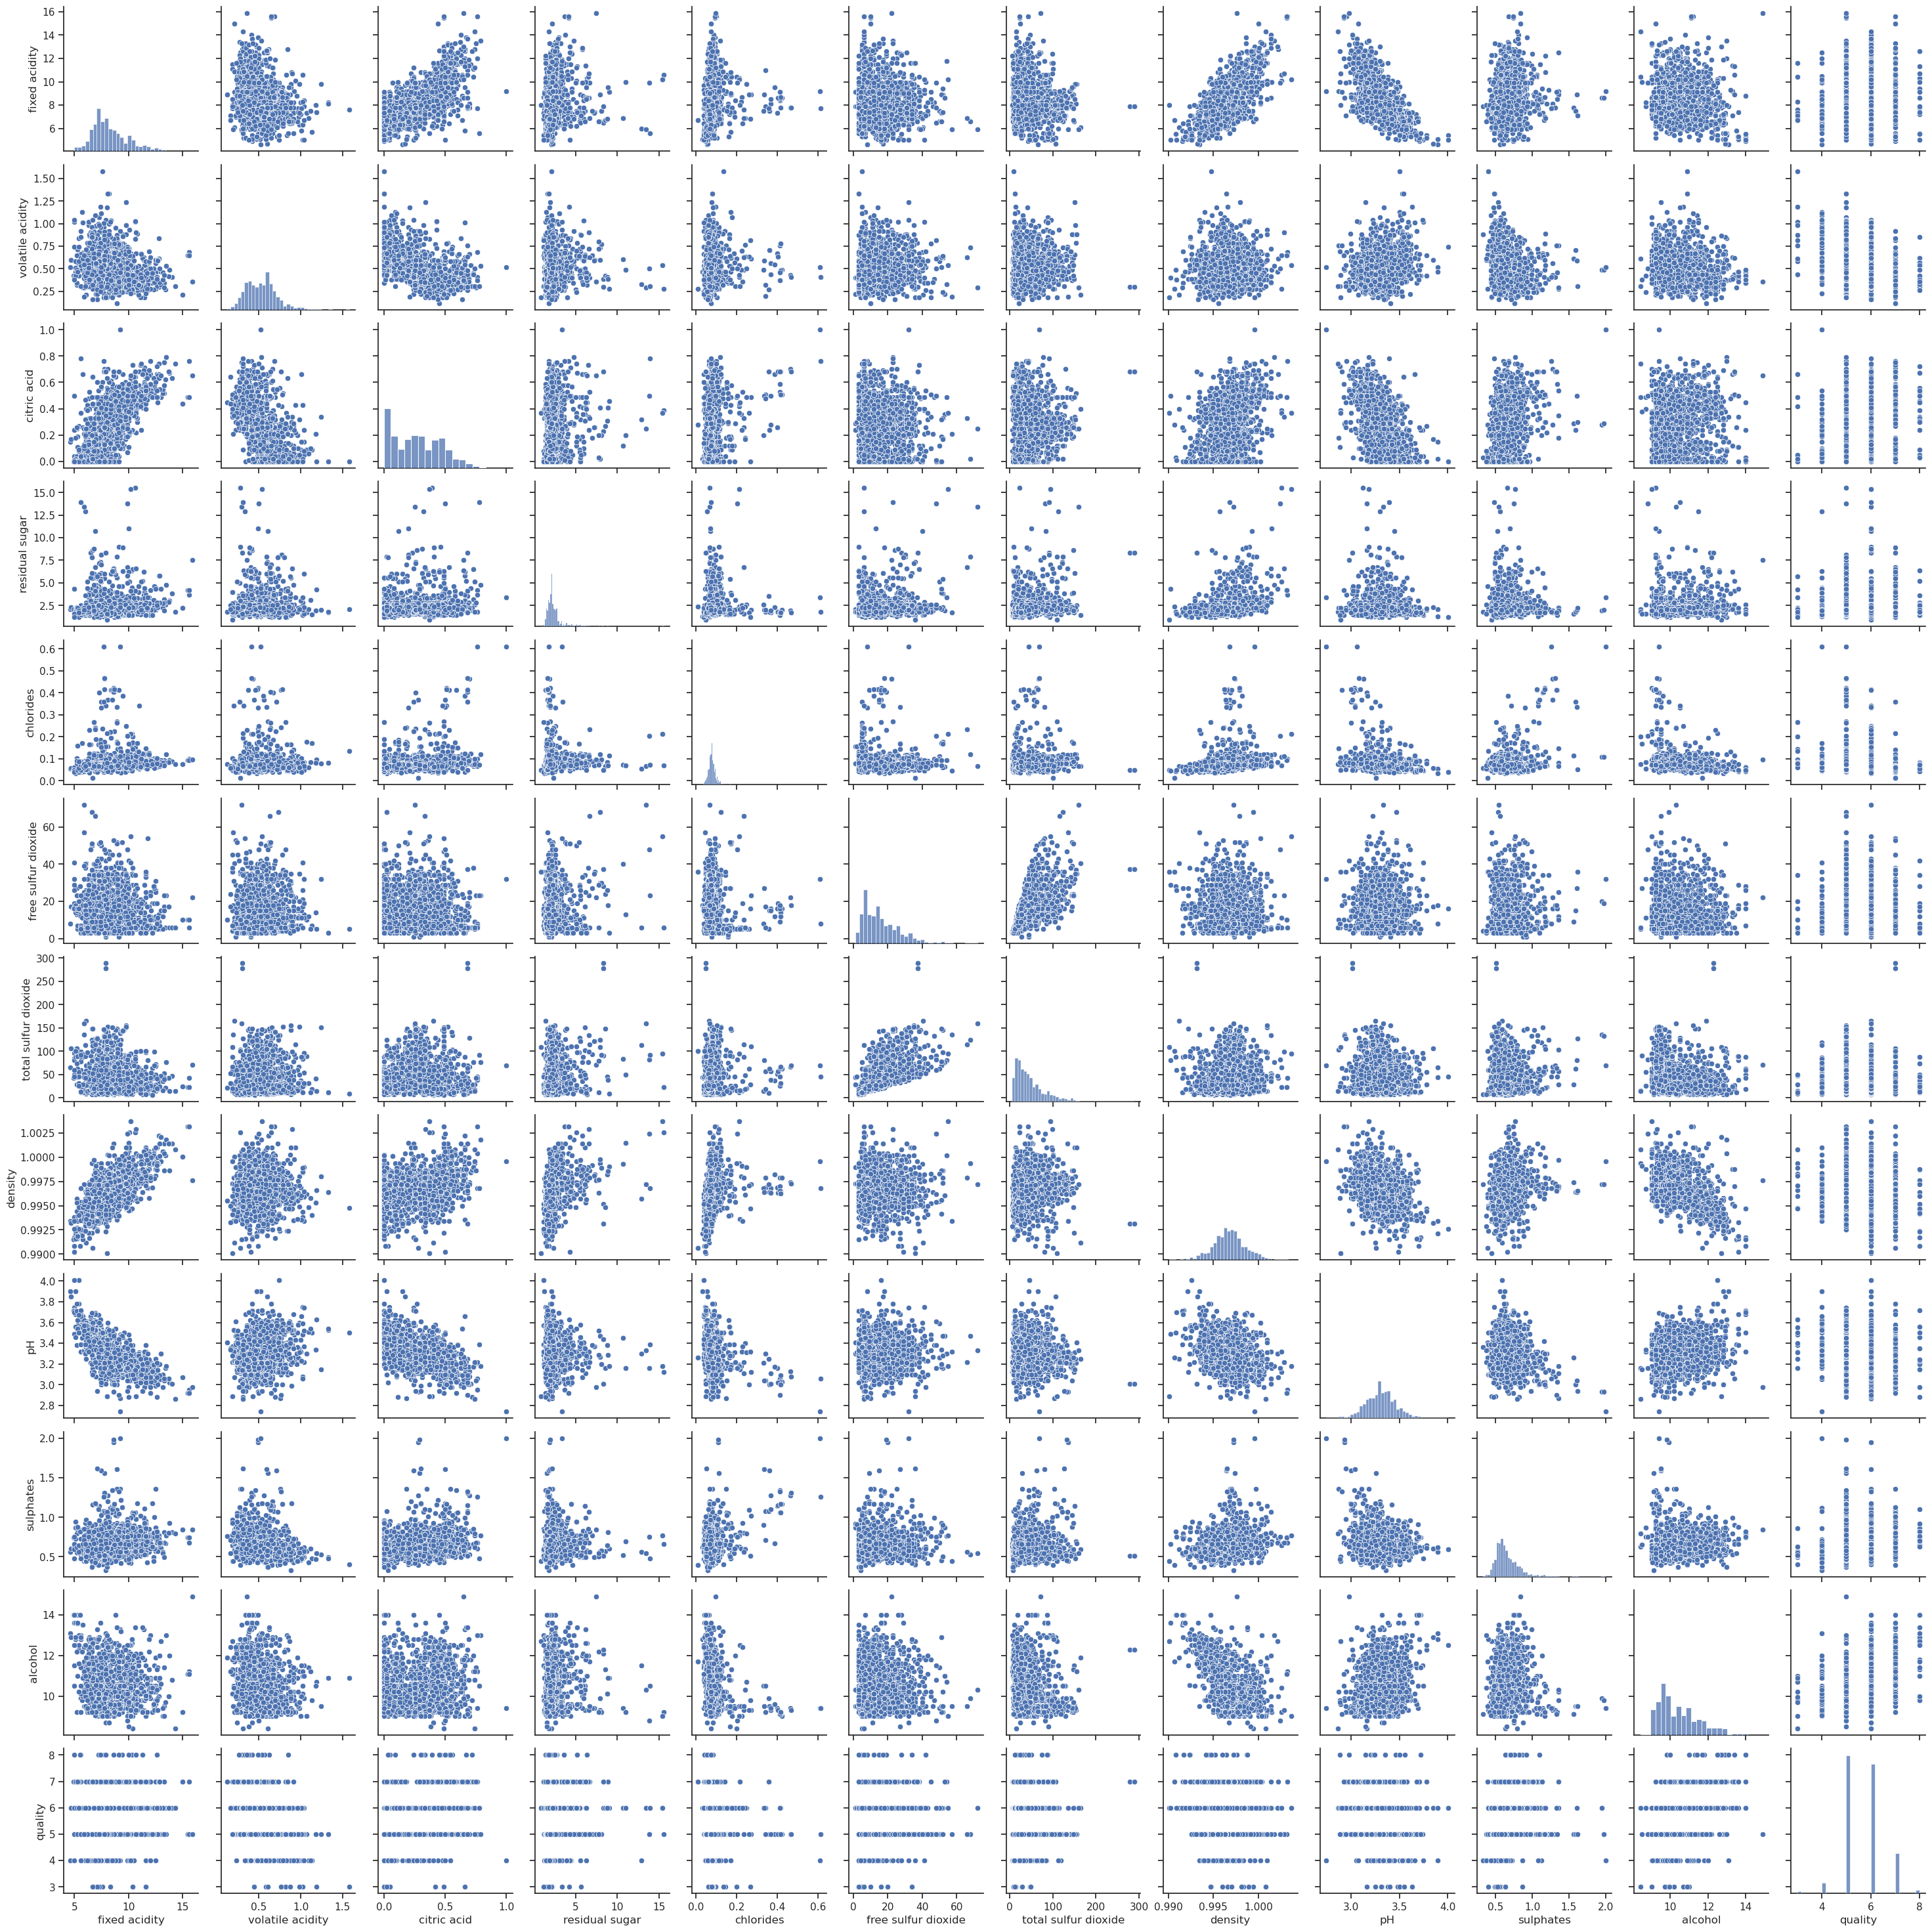

In [7]:
sns.set(style="ticks")

sns.pairplot(df.toPandas())
plt.show()

In [28]:
cols = df.columns

In [29]:
# Определяем векторизатор и индексатор
from pyspark.ml.feature import StringIndexer, VectorAssembler

stages = []
label_stringIdx = StringIndexer(inputCol = 'quality', outputCol = 'label')
stages += [label_stringIdx]
assembler = VectorAssembler(inputCols=df.columns[:-1], outputCol="features")
stages += [assembler]


In [30]:
# Определяем конвейер
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [31]:
# Делим данные на тренировочную и тестовую выборки
train, test = df.randomSplit([0.8, 0.2], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1324
Test Dataset Count: 275


***Logistic Regression***

In [32]:
from pyspark.ml.classification import LogisticRegression

In [40]:
# Обучаем модель
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
lr_model = lr.fit(train)

# Предсказываем
predictions = lr_model.transform(test)

# Показываем результаты
lr_preds = predictions.select("features", "label", "probability", "prediction")
lr_preds.show(truncate=False)

# spark.stop()

+-----------------------------------------------------------+-----+------------------------------------------------------------------------------------------------------------------------------+----------+
|features                                                   |label|probability                                                                                                                   |prediction|
+-----------------------------------------------------------+-----+------------------------------------------------------------------------------------------------------------------------------+----------+
|[5.3,0.715,0.19,1.5,0.161,7.0,62.0,0.99395,3.62,0.61,11.0] |0.0  |[0.5407897435259882,0.20952365077530985,0.010947067972566876,0.23534421660097635,6.112165500648572E-4,0.002784104575093778]   |0.0       |
|[5.6,0.54,0.04,1.7,0.049,5.0,13.0,0.9942,3.72,0.58,11.4]   |0.0  |[0.17977185224054384,0.6180750088602474,0.10333757784717576,0.09351598425102206,0.0046944457958613085,6.05131

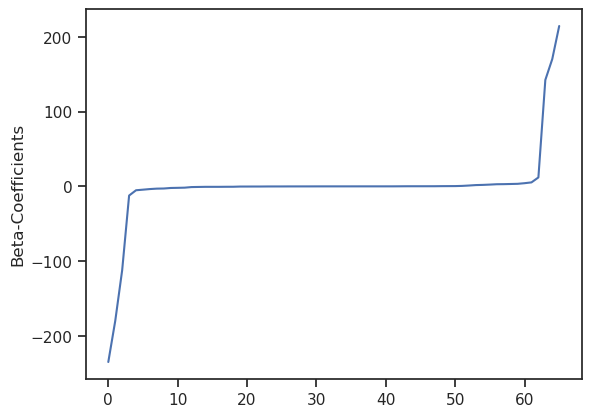

In [41]:
beta = np.sort(lr_model.coefficientMatrix.values)
plt.plot(beta)
plt.ylabel('Beta-Coefficients')
plt.show()

In [42]:
trainingSummary = lr_model.summary
accuracy = trainingSummary.accuracy
precision = trainingSummary.precisionByLabel
recall = trainingSummary.recallByLabel

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6125377643504532
Precision: [0.6786833855799373, 0.5595854922279793, 0.53, 0.14285714285714285, 0.0, 0.0]
Recall: [0.7583187390542907, 0.6206896551724138, 0.3212121212121212, 0.022222222222222223, 0.0, 0.0]


In [36]:
predictions.filter((F.col('prediction') == 1))\
    .show(20, True)

+-----+--------------------+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+----------+
|label|            features|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|       rawPrediction|         probability|prediction|
+-----+--------------------+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+----------+
|  0.0|[5.6,0.54,0.04,1....|          5.6|            0.54|       0.04|           1.7|    0.049|                5.0|                13.0| 0.9942|3.72|     0.58|   11.4|      5|[1.55193829263183...|[0.17977185224054...|       1.0|
|  0.0|[5.6,0.605,0.05,2...|          5.6|           0.605|       0.05|         

In [37]:
predictions.filter((F.col('prediction') == 1.0))\
    .count()

124

In [39]:
predictions.show()

+-----+--------------------+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+----------+
|label|            features|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|       rawPrediction|         probability|prediction|
+-----+--------------------+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+----------+
|  0.0|[5.3,0.715,0.19,1...|          5.3|           0.715|       0.19|           1.5|    0.161|                7.0|                62.0|0.99395|3.62|     0.61|   11.0|      5|[2.95576216348806...|[0.54078974352598...|       0.0|
|  0.0|[5.6,0.54,0.04,1....|          5.6|            0.54|       0.04|         

In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.5773869163740409


In [44]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder().addGrid(lr.maxIter, [500]) 
                                .addGrid(lr.regParam, [0]) 
                                .addGrid(lr.elasticNetParam, [1]) 
                                .build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.585165929855585

In [45]:
predictions.show()

+-----+--------------------+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+----------+
|label|            features|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|       rawPrediction|         probability|prediction|
+-----+--------------------+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+----------+
|  0.0|[5.3,0.715,0.19,1...|          5.3|           0.715|       0.19|           1.5|    0.161|                7.0|                62.0|0.99395|3.62|     0.61|   11.0|      5|[4.70385204875069...|[0.59488497368325...|       0.0|
|  0.0|[5.6,0.54,0.04,1....|          5.6|            0.54|       0.04|         

Вывод: Результат получился не очень, очевидно нужно было создать новые признаки, однако никаких идей в голову не пришло.